In [1]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm
from reskit.core import Transformer, Pipeliner

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import os
import pandas as pd
import numpy as np

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

from matplotlib import pyplot as plt
%matplotlib inline
import re

from tqdm import tqdm_notebook as tqdm

In [2]:
def get_autism(path_to_read='../Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict

In [8]:
def matrix_eig(data):
    #new_data = {}
    #new_data['y'] = data['y']
    data['curs'] = np.zeros(shape = (data['X'].shape[0], data['X'].shape[1]))
    for i in np.arange(data['X'].shape[0]):
        curs, vecs = np.linalg.eig(data['X'][i])
        indx = abs(curs).argsort()
        vecs = vecs[indx]
        curs = curs[indx]
        data['curs'][i] = abs(curs)
        #data['X_vec'][i] = convert(vecs.dot(np.diag(curs)).T, 'mat2vec', 264)
    return data

#Функция преобразования матрицы в вектор и наоборот
def convert(A, mode, size = 264):
    if mode == 'mat2vec':
        A_vec = np.reshape(A, A.shape[0]*A.shape[1])
        return A_vec
        
    if mode == 'vec2mat':
        A_mat = np.reshape(A, (size, A.shape[0] / size ))
        return A_mat

In [26]:
params = {
    'text.usetex'         : True,
    'text.latex.unicode'  : True,
    'text.latex.preamble' : r"\usepackage[T2A]{fontenc}",
    'font.size'           : 15,
    'font.family'         : 'lmodern'
    }

plt.rcParams.update(params)



def print_boxplot(data2, figsize = (10.5,6.5), save = False):
    fig, ax2 = plt.subplots(1, 1, sharey=True, figsize=figsize)
    
    bp  = ax2.boxplot(data2, 0, '')
    
    #x = np.arange(len(data1))
    #ax1.plot(x, data1)
    
    plt.setp(bp['boxes'],    color='DarkGreen')
    plt.setp(bp['whiskers'], color='DarkOrange', linestyle = '-')
    plt.setp(bp['medians'],  color='DarkBlue')
    plt.setp(bp['caps'],     color='Gray')
    
    #ax1.set_title(r'Process of learning')
    ax2.set_title(r'BoxPlot')
    #ax1.set_ylabel(r'ROC AUC mean')
    #ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    ax2.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    
    plt.show()
    if save: fig.savefig('fig.png', dpi = 300)

### Обучим одну модель на X_tr

In [9]:
data = '../Data/dti/'
data = Transformer(get_autism).fit_transform(data)
data = Transformer(binar_norm).fit_transform(data)
data = Transformer(matrix_eig).fit_transform(data)

In [10]:
curs = data['curs']

In [19]:
curs_sort = []
for i in range(264):
    curs_sort.append(curs[:,i])

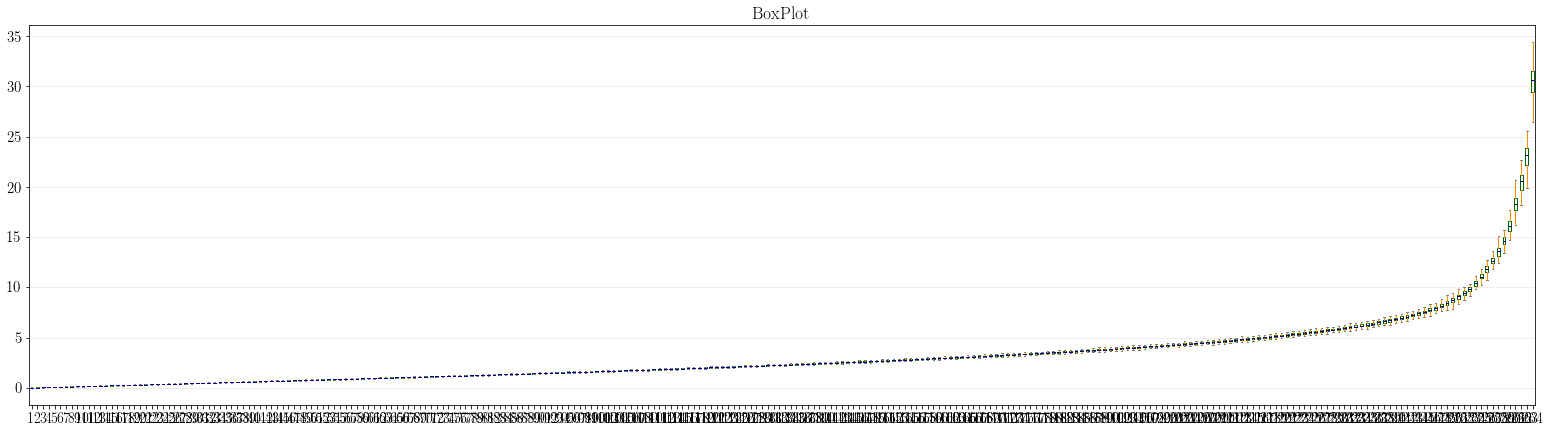

In [28]:
print_boxplot(curs_sort, figsize=(27, 7), save=True)